**Sentiment analysis**

In [ ]:
# !pip install datasets

In [ ]:
# !huggingface-cli login

In [ ]:
# !pip install numpy==1.26.4 scipy==1.11.4 gensim==4.3.1 tsfresh==0.20.0 tensorflow==2.15

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/kdave/Indian_Financial_News/training_data_26000.csv")

In [ ]:
# pd.set_option('display.max_colwidth', None)
df.head()

,URL,Content,Summary,Sentiment
0,https://www.moneycontrol.com/news/business/eco...,US consumer spending dropped by a record in Ap...,consumer spending plunges 13.6 percent in Apri...,Negative
1,https://www.businesstoday.in/top-story/state-r...,State-run lenders require an urgent Rs 1.2 tri...,government will have to take a bulk of the tab...,Negative
2,https://www.financialexpress.com/economy/covid...,Apparel exporters on Wednesday urged the gover...,exporters are facing issues in terms of raw ma...,Negative
3,https://www.moneycontrol.com/news/business/mar...,Asian shares battled to extend a global reboun...,the dollar loses some ground on the safe haven...,Negative
4,https://www.financialexpress.com/industry/six-...,After India’s sovereign credit rating fell to ...,six Indian public-sector undertakings have tak...,Negative


In [ ]:
df["Sentiment"]=df["Sentiment"].apply(lambda x: 2 if x=="Positive" else 0 if x=="Negative" else 1)
df.head()

,URL,Content,Summary,Sentiment
0,https://www.moneycontrol.com/news/business/eco...,US consumer spending dropped by a record in Ap...,consumer spending plunges 13.6 percent in Apri...,0
1,https://www.businesstoday.in/top-story/state-r...,State-run lenders require an urgent Rs 1.2 tri...,government will have to take a bulk of the tab...,0
2,https://www.financialexpress.com/economy/covid...,Apparel exporters on Wednesday urged the gover...,exporters are facing issues in terms of raw ma...,0
3,https://www.moneycontrol.com/news/business/mar...,Asian shares battled to extend a global reboun...,the dollar loses some ground on the safe haven...,0
4,https://www.financialexpress.com/industry/six-...,After India’s sovereign credit rating fell to ...,six Indian public-sector undertakings have tak...,0


In [ ]:
df["Sentiment"].value_counts()

,count
Sentiment,
0,8987
1,8987
2,8987


In [ ]:
import re
import nltk
import numpy as np

In [ ]:
from transformers import AutoConfig

# Load the configuration first
config = AutoConfig.from_pretrained("bert-base-uncased", num_labels=3)

# Load the model using the modified configuration
bert_model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bert_tokenizer=AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
def preprocess_function(batch):
    source_ids=bert_tokenizer(batch['Summary'], truncation=True, padding="max_length", max_length=128)

    return {
        "input_ids": source_ids["input_ids"],
        "attention_mask": source_ids["attention_mask"],
        "token_type_ids": source_ids["token_type_ids"],
        "labels": batch["Sentiment"]
    }

In [ ]:
# Install the datasets library if you haven't already
# !pip install datasets

from datasets import Dataset

# Convert the pandas DataFrame to a datasets Dataset
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

# Now call the map function on the datasets Dataset object
df_preprocessed_train = df_train.map(preprocess_function, batched=True)
df_preprocessed_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/21568 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

In [ ]:
df_preprocessed_train

Dataset({
    features: ['URL', 'Content', 'Summary', 'Sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'token_type_ids', 'labels'],
    num_rows: 21568
})

In [ ]:
df_preprocessed_test

Dataset({
    features: ['URL', 'Content', 'Summary', 'Sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'token_type_ids', 'labels'],
    num_rows: 5393
})

In [ ]:
import tensorflow as tf
# from tensorflow import keras

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": df_preprocessed_train["input_ids"],
        "attention_mask": df_preprocessed_train["attention_mask"],
        "token_type_ids": df_preprocessed_train["token_type_ids"]
    },
    df_preprocessed_train["labels"]
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": df_preprocessed_test["input_ids"],
        "attention_mask": df_preprocessed_test["attention_mask"],
        "token_type_ids": df_preprocessed_test["token_type_ids"]
    },
    df_preprocessed_test["labels"]
)).batch(16)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
bert_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

In [ ]:
history=bert_model.fit(train_dataset,epochs=5,validation_data=test_dataset)

Epoch 1/5
1348/1348 [==============================] - 643s 441ms/step - loss: 0.5550 - accuracy: 0.7633 - val_loss: 0.3663 - val_accuracy: 0.8617
Epoch 2/5
1348/1348 [==============================] - 591s 438ms/step - loss: 0.2256 - accuracy: 0.9186 - val_loss: 0.3197 - val_accuracy: 0.8984
Epoch 3/5
1348/1348 [==============================] - 591s 438ms/step - loss: 0.1224 - accuracy: 0.9591 - val_loss: 0.3182 - val_accuracy: 0.9093
Epoch 4/5
1348/1348 [==============================] - 591s 439ms/step - loss: 0.0812 - accuracy: 0.9740 - val_loss: 0.3456 - val_accuracy: 0.9097
Epoch 5/5
1348/1348 [==============================] - 591s 439ms/step - loss: 0.0611 - accuracy: 0.9800 - val_loss: 0.3523 - val_accuracy: 0.9049


In [ ]:
import matplotlib.pyplot as plt

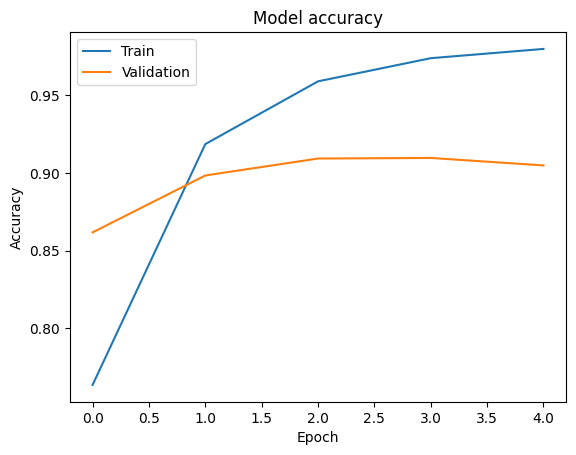

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

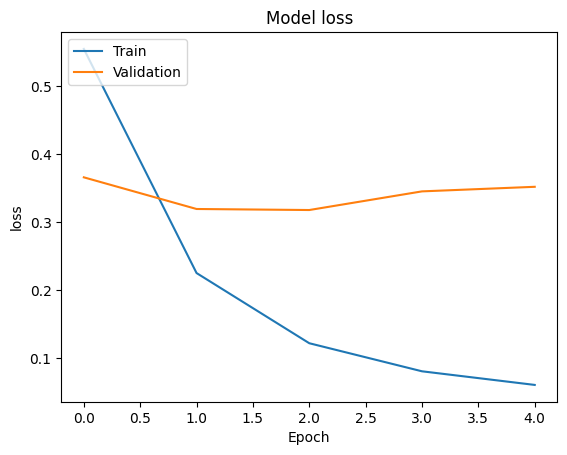

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
bert_model.save('bert_sentiment_financial_model.keras')

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
bert_tokenizer.save_pretrained('bert_financial_tokenizer')

('bert_financial_tokenizer/tokenizer_config.json',
 'bert_financial_tokenizer/special_tokens_map.json',
 'bert_financial_tokenizer/vocab.txt',
 'bert_financial_tokenizer/added_tokens.json',
 'bert_financial_tokenizer/tokenizer.json')

In [ ]:
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     # You can add more metrics here, e.g., accuracy, precision, recall, F1-score
#     from sklearn.metrics import accuracy_score
#     accuracy = accuracy_score(labels, preds)
#     return {"accuracy": accuracy}

In [ ]:
# !cp -r lstm_sentiment_model.h5 /content/drive/MyDrive/

**Text Summarization**

In [ ]:
# Load model directly
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer

bart_tokenizer = AutoTokenizer.from_pretrained("ainize/bart-base-cnn")
bart_model = AutoModelForSeq2SeqLM.from_pretrained("ainize/bart-base-cnn")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/kdave/Indian_Financial_News/training_data_26000.csv")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
# pd.set_option('display.max_colwidth', None)
df.head()

,URL,Content,Summary,Sentiment
0,https://www.moneycontrol.com/news/business/eco...,US consumer spending dropped by a record in Ap...,consumer spending plunges 13.6 percent in Apri...,Negative
1,https://www.businesstoday.in/top-story/state-r...,State-run lenders require an urgent Rs 1.2 tri...,government will have to take a bulk of the tab...,Negative
2,https://www.financialexpress.com/economy/covid...,Apparel exporters on Wednesday urged the gover...,exporters are facing issues in terms of raw ma...,Negative
3,https://www.moneycontrol.com/news/business/mar...,Asian shares battled to extend a global reboun...,the dollar loses some ground on the safe haven...,Negative
4,https://www.financialexpress.com/industry/six-...,After India’s sovereign credit rating fell to ...,six Indian public-sector undertakings have tak...,Negative


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
def summary_preprocess_function(batch):
    source_ids=bart_tokenizer(batch['Content'], truncation=True, padding="max_length", max_length=128)
    target_ids=bart_tokenizer(batch['Summary'], truncation=True, padding="max_length", max_length=128)
    labels=target_ids["input_ids"]
    labels=[[(number if number!=bart_tokenizer.pad_token_id else -100) for number in individual_label] for individual_label in labels]

    return {
        "input_ids": source_ids["input_ids"],
        "attention_mask": source_ids["attention_mask"],
        "labels": labels
    }


In [ ]:
# Install the datasets library if you haven't already
# !pip install datasets

from datasets import Dataset

# Convert the pandas DataFrame to a datasets Dataset
# df_train = Dataset.from_pandas(df_train)
# df_test = Dataset.from_pandas(df_test)

df_summary_preprocessed_train=df_train.map(summary_preprocess_function, batched=True)
df_summary_preprocessed_test=df_test.map(summary_preprocess_function, batched=True)

Map:   0%|          | 0/21568 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

In [ ]:
df_summary_preprocessed_train

Dataset({
    features: ['URL', 'Content', 'Summary', 'Sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 21568
})

In [ ]:
df_summary_preprocessed_test

Dataset({
    features: ['URL', 'Content', 'Summary', 'Sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5393
})

In [ ]:
training_args=TrainingArguments(
    output_dir="/content",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    remove_unused_columns=True,
    report_to="none"
)

In [ ]:
trainer=Trainer(
    model=bart_model,
    args=training_args,
    train_dataset=df_summary_preprocessed_train,
    eval_dataset=df_summary_preprocessed_test
)

In [ ]:
trainer.train()

Step,Training Loss
500,1.980100
1000,1.742900
1500,1.610900
2000,1.441700
2500,1.425000
3000,1.330100
3500,1.285600
4000,1.266600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=4044, training_loss=1.50762780318746, metrics={'train_runtime': 2522.0012, 'train_samples_per_second': 25.656, 'train_steps_per_second': 1.603, 'total_flos': 4931548474245120.0, 'train_loss': 1.50762780318746, 'epoch': 3.0})

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(eval_results)

{'eval_loss': 1.2864130735397339, 'eval_runtime': 65.8327, 'eval_samples_per_second': 81.92, 'eval_steps_per_second': 10.253, 'epoch': 3.0}


In [ ]:
# Save the model using the save_pretrained method
bart_model.save_pretrained('bart_summary_financial_model')

In [ ]:
bart_tokenizer.save_pretrained('bart_financial_tokenizer')

('bart_financial_tokenizer/tokenizer_config.json',
 'bart_financial_tokenizer/special_tokens_map.json',
 'bart_financial_tokenizer/vocab.json',
 'bart_financial_tokenizer/merges.txt',
 'bart_financial_tokenizer/added_tokens.json',
 'bart_financial_tokenizer/tokenizer.json')

In [ ]:
!cp -r bart_summary_financial_model /content/drive/MyDrive/

In [ ]:
!cp -r bart_financial_tokenizer /content/drive/MyDrive/